<a href="https://colab.research.google.com/github/Shahar19/Python/blob/master/ML_Project_Shahar_B_Feb_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ML Final Project - Company's industry - Shahar B and Nethanel Zajfman, Feb 2020**

Predict which industry does a company / workplace / business belong to

*MultiClass Classification*

# **Import Packages**


In [ ]:
import pandas as pd
import numpy as np
import random
from functools import reduce

# Vizualisation
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

# NLP
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from wordcloud import WordCloud, STOPWORDS

# Preprocessing
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample

#Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, DMatrix
from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, classification_report, auc

import pickle
import warnings
warnings.filterwarnings('ignore')

# **Get the dataset & Dataset Overview**

## **Dataset Overview**

**Data**

The raw data file contains 29,024 rows, and 39 columns.
The data is private and confidential, and therefore, was edited and encrypted before usage.

Each record is a company/business entity that exist in LS db and was processed.

Releveant columns description:

- target_industry: the target variable, str, (H / FS / R)
- LS_C_Name - Company Name
- LS_C_Size_-_Exact/range - Company size
- LS_C_Revenue_-_Exact/range - Company yearly income
- LS_C_Region
- LS_C_Country
- LS_C_State
- LS_C_City
- LS_C_SIC - Company standrad industry classification number
- LS_C_Description - Company Description
- LS_C_Ownership - Company Ownership
- LS_C_Specialties - Company Specialties (company indicated on LI).
- LS_C_Expertise - agg of company's employees skills
- LS_C_LI_followers - Li followers
- LS_C_LI_connections - # of Li connections
- LS_C_Founded_Year - Year of company foundation
etc... 

## **Upload dataset CSV format file**

In [ ]:
# def user_upload_multiple_files():
#     number_of_files = int(input("please enter number of files to upload\n"))

#     for file in range(0,number_of_files):
#         if 'google.colab' in modules:
#             from google.colab import files
#             uploaded = files.upload()
# user_upload_multiple_files()

# **Data Manipulation and EDA - Research**

## **Read data and define target variable**

### **Read File**

In [ ]:
df = pd.read_csv('industry_classifier_data.csv', encoding='UTF-8', index_col='Record_Id')

### **Target Varibale Definition**

In [ ]:
target_variable = 'target_industry'

## **Data manupulation - initial**

### **Remove irrelevant Columns**

#### **Remove unuseable columns**

In [ ]:
columns_drop_list = ['LS_C_Size_-_Range', 'LS_C_Revenue_-_Range','LS_C_Address', 'LS_C_Zipcode', 'LS_C_SIC_Description',
                  'LS_C_8-Digit_SIC', 'LS_C_NAICS', 'LS_C_Ticker_Symbol']

df.drop(columns_drop_list, axis=1, inplace=True)

#### **Remove columns with less than 20,000 not null rows**

In [ ]:
df = df.dropna(thresh=len(df) - 20000, axis=1)

### **Rename Columns**

In [ ]:
df.rename({c: c[5:] for c in df.columns if c.startswith('LS_C_')}, axis='columns', inplace=True)

## **Expolatatory Data Analysis - (EDA)**

### **Data head, tail, describe & info**

#### **Data head**

In [ ]:
df.head()

target_industry            Name  ...  LI_followers  LI_connections
Record_Id                                  ...                              
148                     R         Walmart  ...     1629147.0        369107.0
12                     FS             PNC  ...      158857.0         52679.0
199                    FS  Guild Mortgage  ...       12916.0          3327.0
88                      R       Nordstrom  ...      353241.0         40586.0
104                    FS     Capital One  ...      387253.0         52290.0

[5 rows x 22 columns]

#### **Data tail**

In [ ]:
df.tail()

target_industry                    Name  ...  LI_followers  LI_connections
Record_Id                                          ...                              
28594                   R         Red Bloom Salon  ...           NaN             NaN
28590                   R         Theater Extreme  ...           NaN             NaN
28630                   R     Your Mobile Pet Vet  ...           NaN             NaN
28671                   H       Ladybug Farms Inc  ...           NaN             NaN
28659                   R  Art Van Furniture, LLC  ...           NaN             NaN

[5 rows x 22 columns]

#### **Data info**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29024 entries, 148 to 28659
Data columns (total 22 columns):
target_industry      29024 non-null object
Name                 29023 non-null object
Size_-_Exact         28892 non-null float64
Revenue_-_Exact      27953 non-null float64
Country              28452 non-null object
Region               28451 non-null object
State                27536 non-null object
City                 28171 non-null object
Website              26234 non-null object
SIC                  27936 non-null float64
NAICS_Description    27951 non-null object
LinkedIn_Profile     25132 non-null object
Description          28916 non-null object
Location_Type        26811 non-null object
Ownership            24017 non-null object
Specialties          15941 non-null object
Expertise            17177 non-null object
Technologies_1       23679 non-null object
Technologies_2       23991 non-null object
Founded_Year         20400 non-null float64
LI_followers         2509

#### **Describe dataset**

In [ ]:
df.describe().T

count          mean  ...         75%           max
Size_-_Exact     28892.0  3.225855e+03  ...       211.0  2.200000e+06
Revenue_-_Exact  27953.0  1.295611e+09  ...  37178344.0  5.144050e+11
SIC              27936.0  6.245310e+03  ...      7374.0  9.999000e+03
Founded_Year     20400.0  1.990112e+03  ...      2011.0  2.019000e+03
LI_followers     25093.0  2.189031e+04  ...      2640.0  7.828840e+06
LI_connections   24039.0  2.001603e+03  ...       201.0  4.010430e+05

[6 rows x 8 columns]

#### **Number of unique values per data point**

In [ ]:
df.nunique()

target_industry          3
Name                 25075
Size_-_Exact          1952
Revenue_-_Exact      18230
Country                 85
Region                   4
State                  146
City                  3972
Website              22206
SIC                    696
NAICS_Description      776
LinkedIn_Profile     21294
Description          21370
Location_Type            3
Ownership                9
Specialties          12680
Expertise            10767
Technologies_1       18934
Technologies_2       19518
Founded_Year           198
LI_followers          5623
LI_connections        2041
dtype: int64

### **Data Vizualisations**

#### **Pair plot by industry**

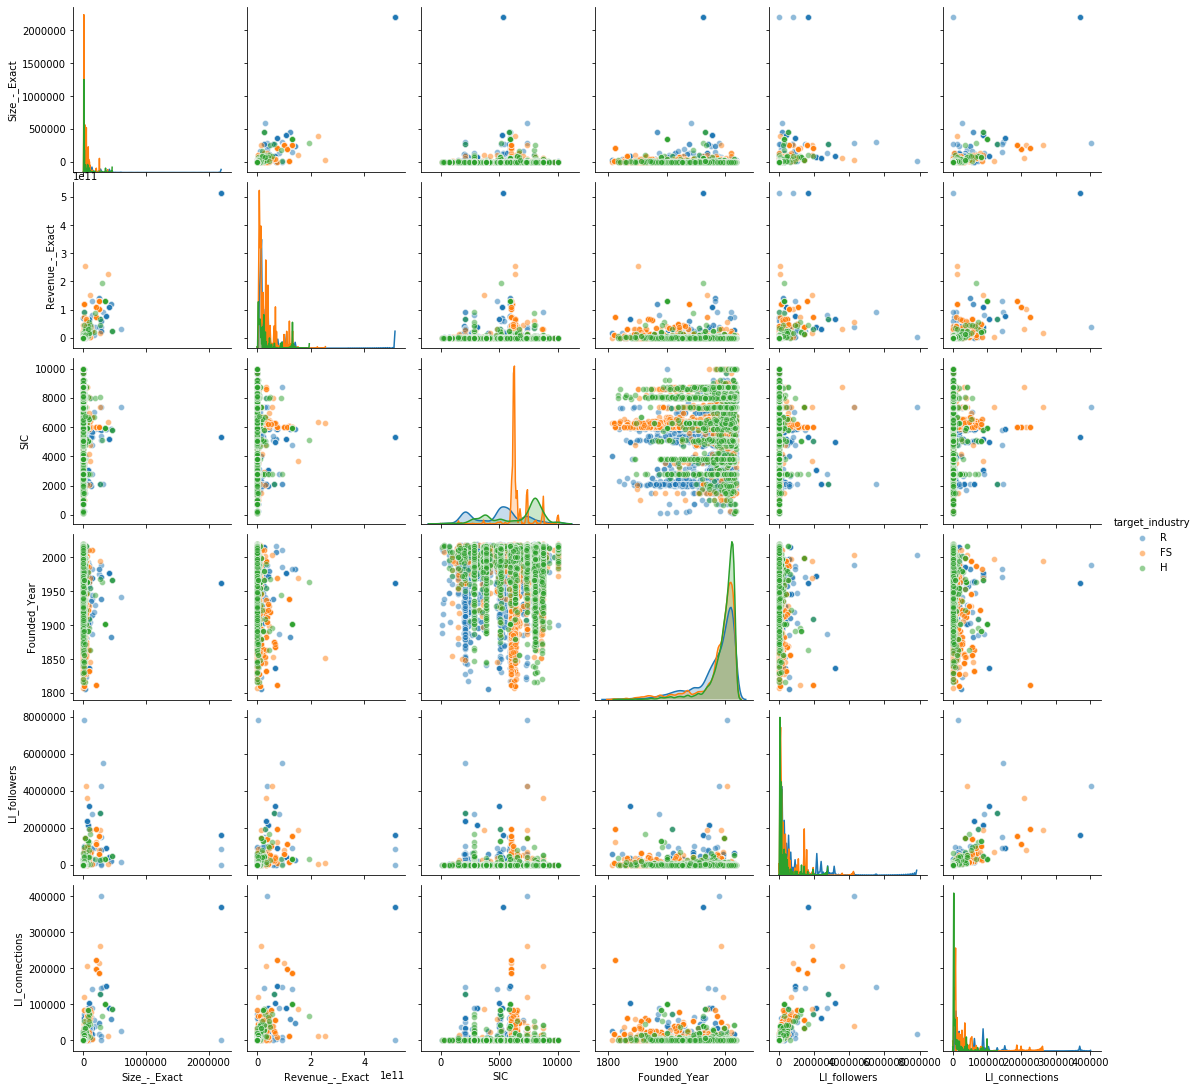

In [ ]:
sns.pairplot(df, hue=target_variable, plot_kws={'alpha': 0.5})

#### **SIC codes - Standard Industrial Classification**

##### **SIC Hisogram**

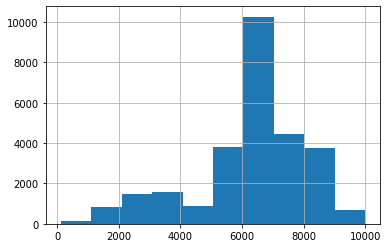

In [ ]:
df['SIC'].hist()

##### **SIC Hisogram - by industry**

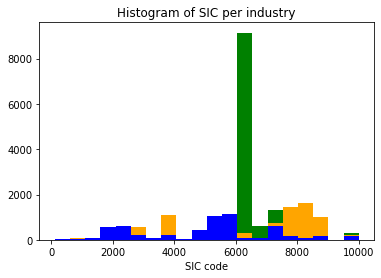

In [ ]:
fig = plt.figure()
ax = fig.gca()
ax.hist(df.loc[df[target_variable]=="FS", 'SIC'], bins=20, color='green')
ax.hist(df.loc[df[target_variable]=="H", 'SIC'], bins=20, color='orange')
ax.hist(df.loc[df[target_variable]=="R", 'SIC'], bins=20, color='blue')
ax.set_title('Histogram of SIC per industry')
ax.set_xlabel('SIC code')
plt.show()

##### **SIC Scatter - by industry**

In [ ]:
markers = {"R": "s", "H": "X", "FS": "D"}
color_dict = dict({'R':'blue',
                  'H':'orange',
                  'FS': 'green'})

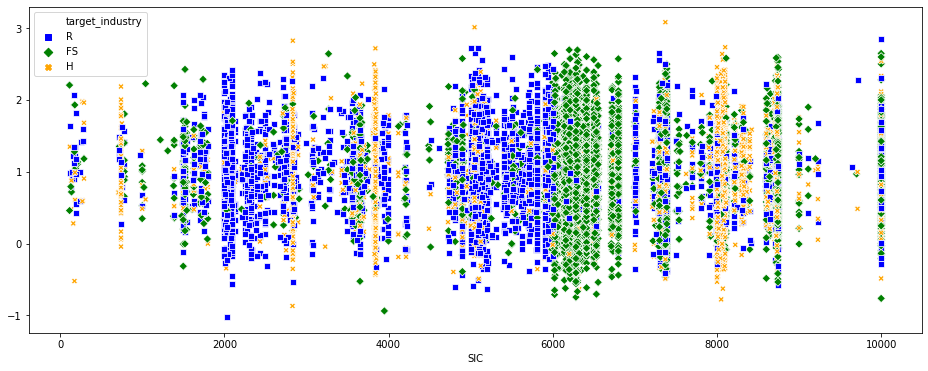

In [ ]:
y = [random.gauss(1, 0.5) for i in range(len(df))]
plt.figure(figsize=(16, 6))
ax = sns.scatterplot(x="SIC", y=y, hue=target_variable, style=target_variable,
                     data=df, alpha=1, markers=markers, palette=color_dict)

***insights***

According to the scatter plot, we can expect that sic codes will help the classifier seperate between the industries, as we can see homogenous groups (same color & marker) within a specific sic range.

HOWEVER, this is a categorical feature (non-continous) with a lot of unique values (696), so we'll need to manipulate and group the data in order to use it

#### **Revenue & Size**

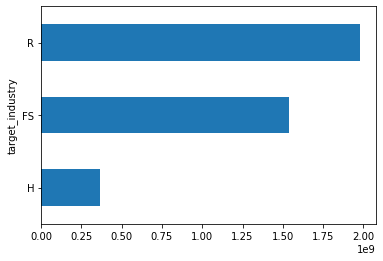

In [ ]:
df.groupby(target_variable)['Revenue_-_Exact'].mean().sort_values().plot.barh()

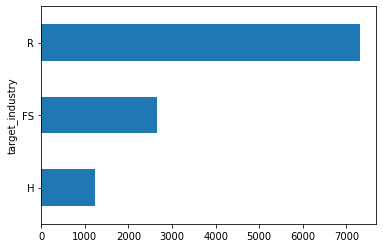

In [ ]:
df.groupby(target_variable)['Size_-_Exact'].mean().sort_values().plot.barh()

***insights***

As expected, according to the bar plot, we can see that the avg revenue (per year) for healthcare is the lowest (public hospitals, etc) if we compare it to big Retail and financial services companies.

#### **Socail data correlation**

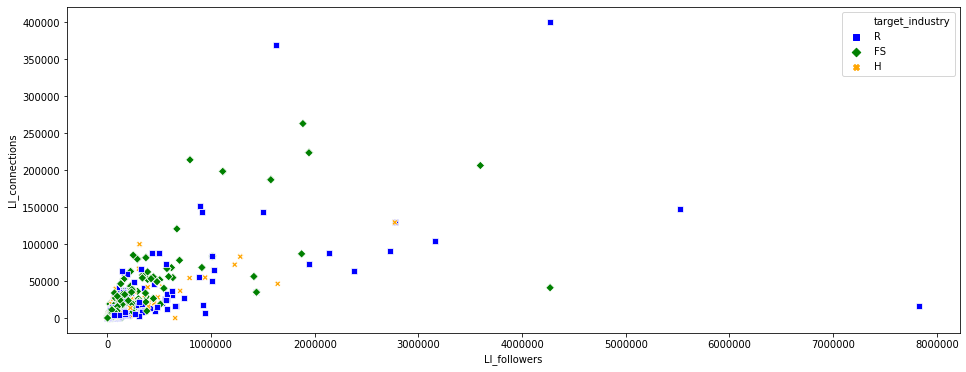

In [ ]:
plt.figure(figsize=(16, 6))
ax = sns.scatterplot(x='LI_followers', y='LI_connections', hue=target_variable, style=target_variable,
                     data=df, alpha=1, markers=markers, palette=color_dict)

#### **Words Visualizations**

##### **Define stop words**

In [ ]:
noisy_words_list = ["help", "products","product", "provide", "services", "service", "business", "united  states", "united states","united state", "support", "solution", "system", "color","client","customer","customers", "need", "company", "partner", "brand","industry", 'team', 'offer', 'based', 'experience', 'year', 'mentioned mentioned', 'not mentioned', 'mentioned']
stopwords = set(STOPWORDS)
stopwords.update(noisy_words_list)

##### **Define words visualization function**

In [ ]:
def generate_words_cloud_vis_multiple_columns(stopwords, n, columns_list):
    for column in columns_list:
        print(f"\nTop {n} words for Company {column} per {target_variable.replace('_', ' ')}:\n")
        for target_value in df[target_variable].unique()[::-1]:
            corpus = " ".join(cell for cell in df[(df[target_variable]==target_value)&(df[column].notnull())][column].str.lower().str.replace("; ", " "))
            wordcloud = WordCloud(stopwords=stopwords, background_color="black", max_words=n).generate(corpus)
            plt.figure(figsize = (16,8))
            plt.imshow(wordcloud, interpolation='bilinear', aspect='auto')
            plt.axis("off")
            plt.title(target_value)
            plt.show()


##### **Show words visualization**


Top 100 words for Company Description per target industry:



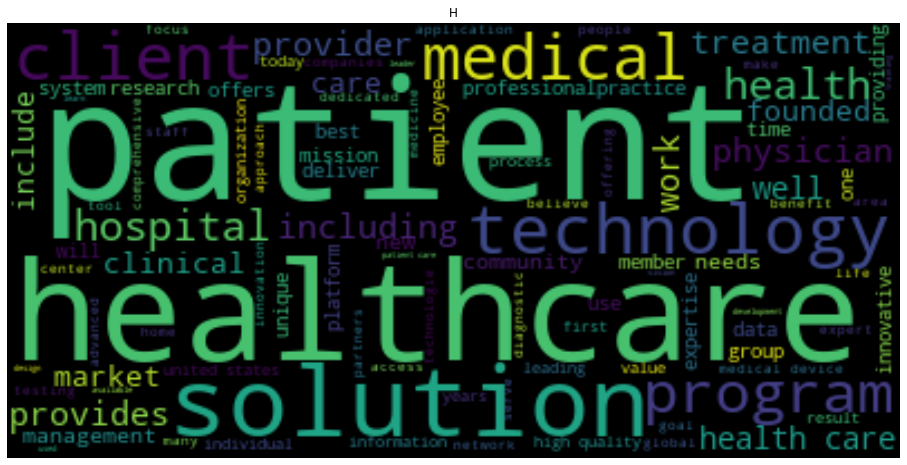

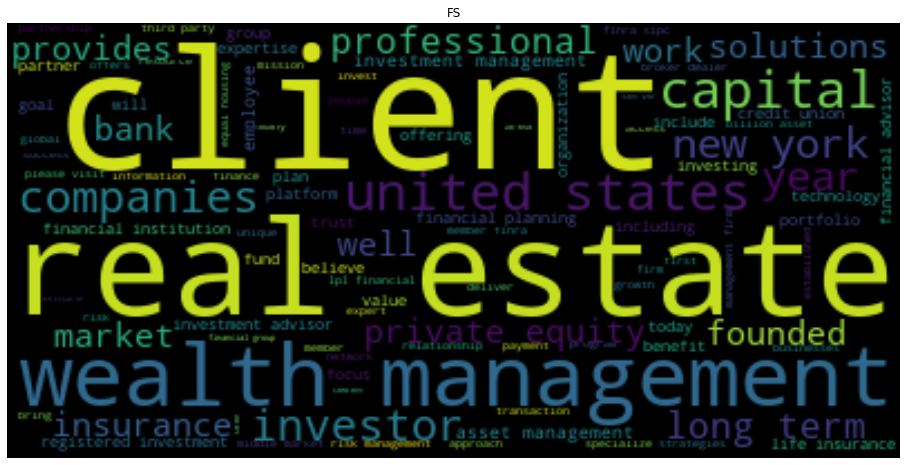

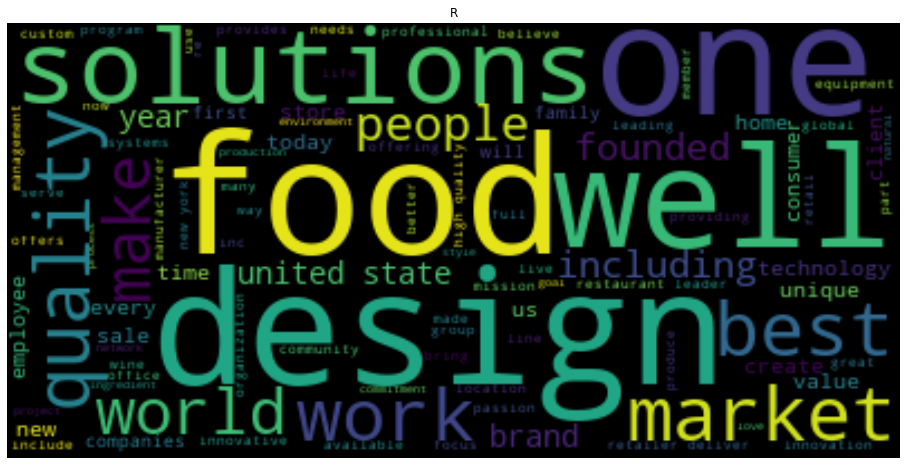


Top 100 words for Company Specialties per target industry:



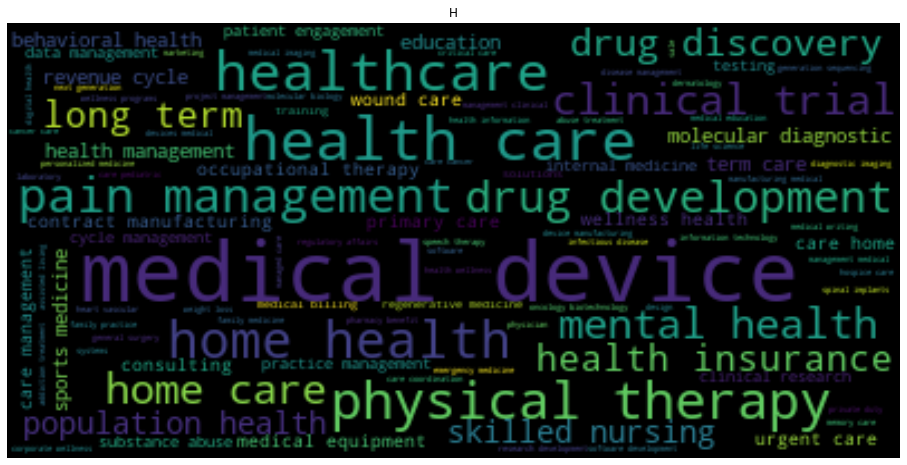

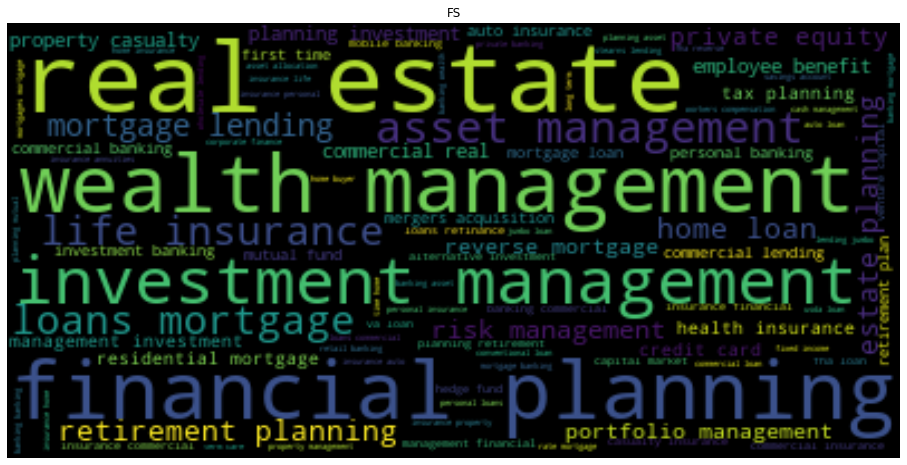

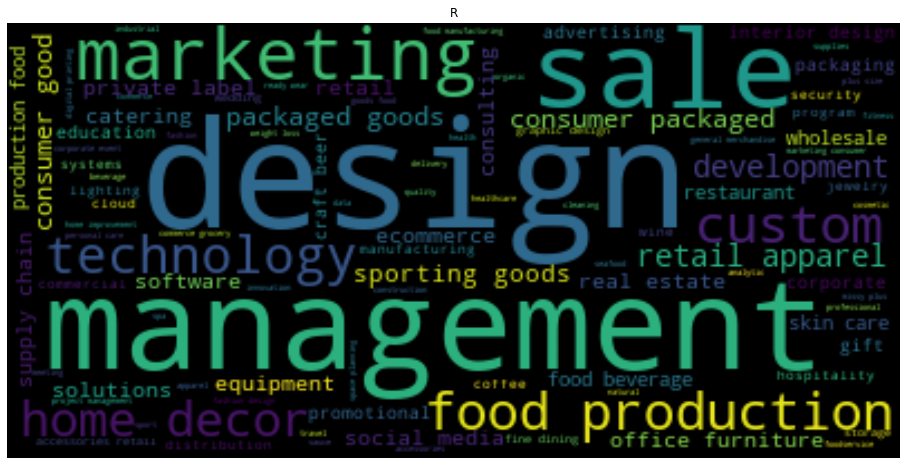


Top 100 words for Company Expertise per target industry:



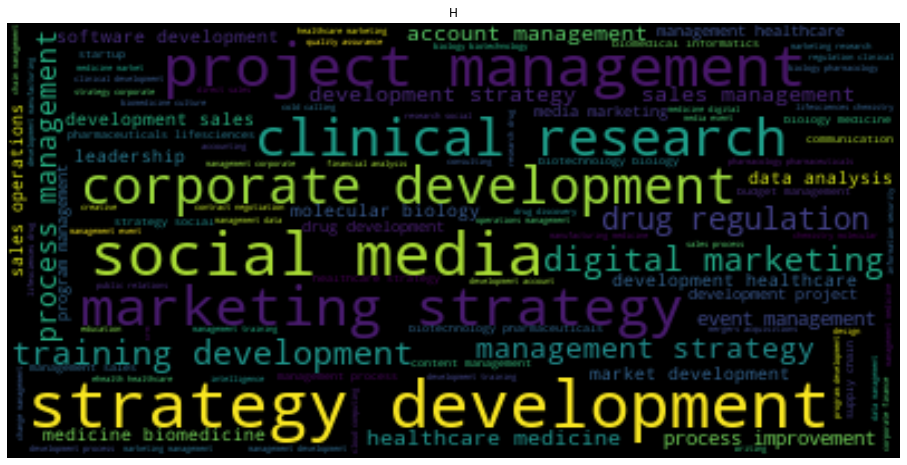

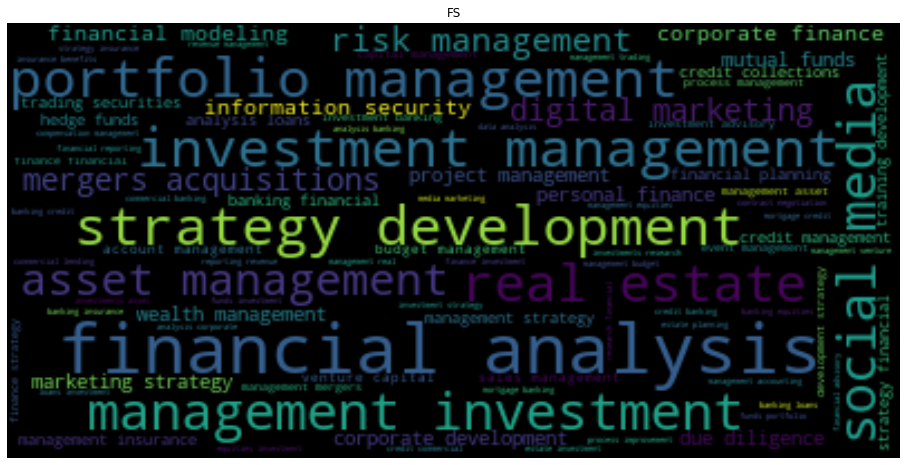

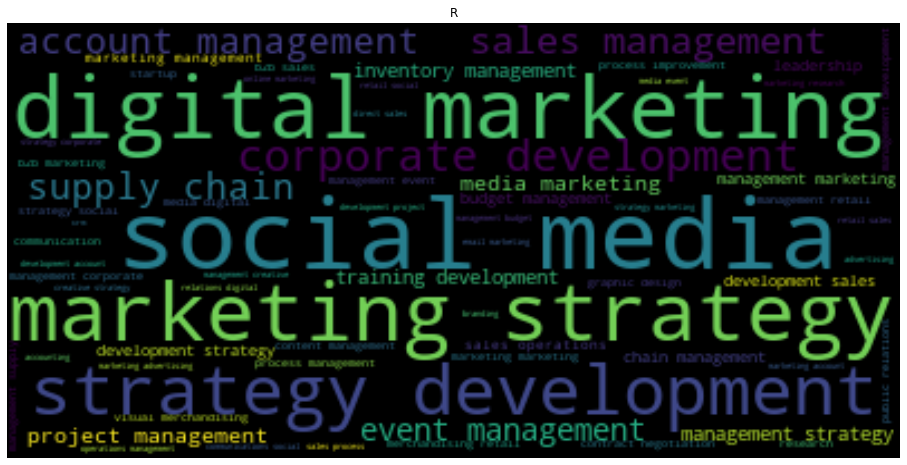


Top 100 words for Company Technologies_1 per target industry:



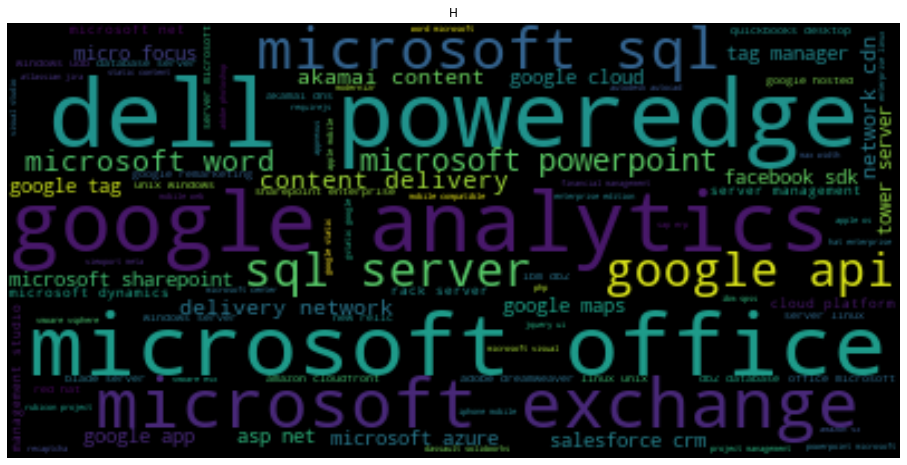

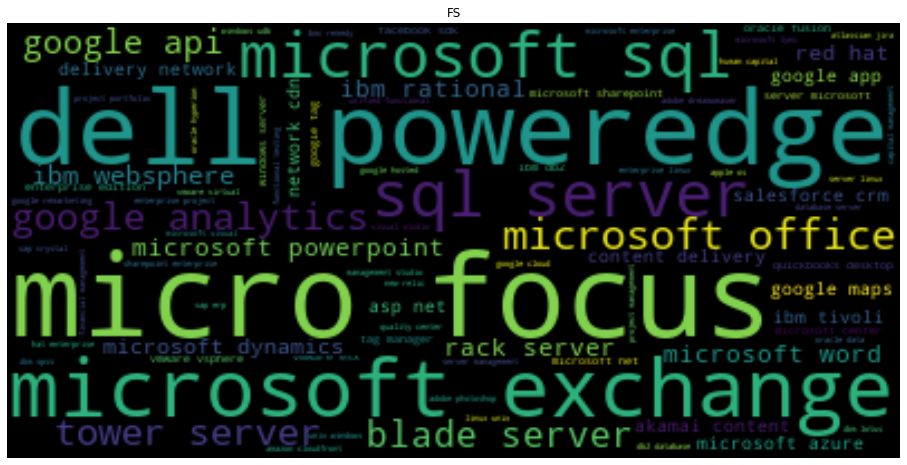

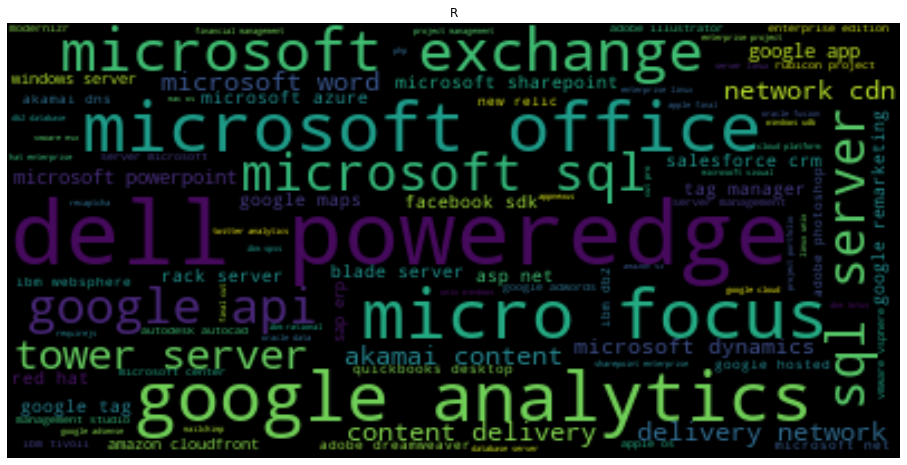


Top 100 words for Company Technologies_2 per target industry:



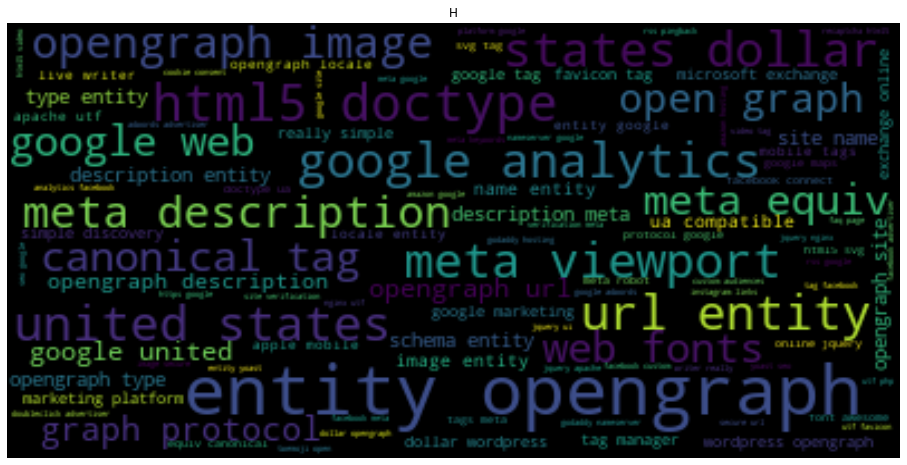

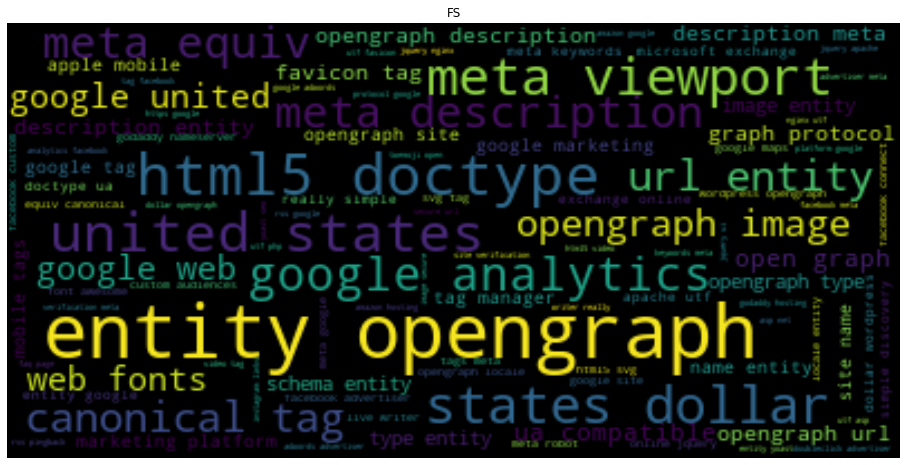

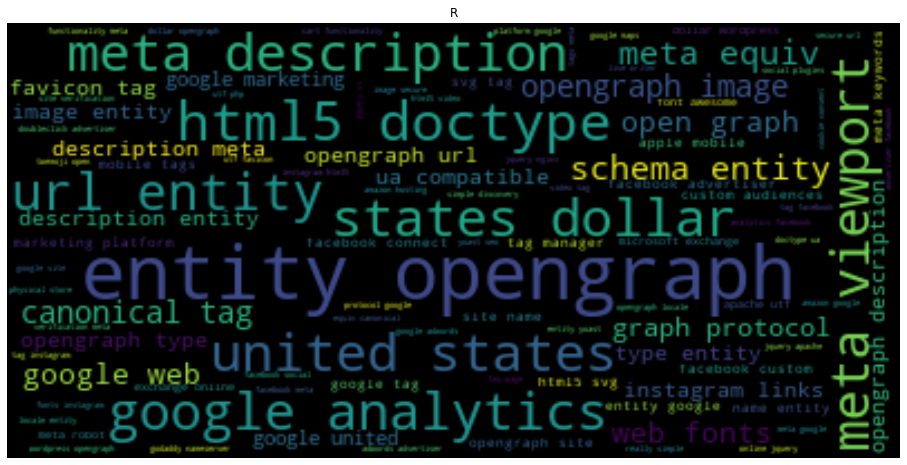

In [ ]:
columns_list = ['Description', 'Specialties', 'Expertise', 'Technologies_1', 'Technologies_2']
n=100

generate_words_cloud_vis_multiple_columns(stopwords=stopwords, n=n, columns_list=columns_list)

***insights***

We can see that a company Description and it's Specialties can help the classifier in seperating the 3 industries classes, specifically in Healthcare (words like healthcare, patient and hospital are very frequent!), and in financial services (private equity, real estate, insurance, etc).

HOWEVER, this is a textual features  with a lot of unique values, so we'll need to manipulate and give a numerical representation in order to use it.

### **Nulls analysis and filling**

#### **Nulls quantity**

In [ ]:
df.isna().sum()

target_industry          0
Name                     1
Size_-_Exact           132
Revenue_-_Exact       1071
Country                572
Region                 573
State                 1488
City                   853
Website               2790
SIC                   1088
NAICS_Description     1073
LinkedIn_Profile      3892
Description            108
Location_Type         2213
Ownership             5007
Specialties          13083
Expertise            11847
Technologies_1        5345
Technologies_2        5033
Founded_Year          8624
LI_followers          3931
LI_connections        4985
dtype: int64

***insights***

We can see a significant nulls quantity in the data, however, it represent the real-life data distribution.

We decided to fill the categorical data with "Not mantioned" category, and the continous features with the mean value per industry. due to the fact that the industry is the target variable and won't be availabe for applying the classifier on the test sample, on the production stage, we decided to fill these nulls features with the mean of the sic category, which will be calculated in production sic special nulls transformer.

#### **Filling nulls - Not Mentioned / filling from other column**

In [ ]:
df['Country'].fillna('No Country', inplace=True)
df['Region'].fillna('No Region', inplace=True)
df['State'].fillna('No State', inplace=True)
df['City'].fillna(df['State'], inplace=True)
df['SIC'].fillna(9999 , inplace=True)
df['NAICS_Description'].fillna('No NAICS_Description', inplace=True)
df['Description'].fillna('no Description', inplace=True)
df['Location_Type'].fillna('no Location_Type', inplace=True)
df['Ownership'].fillna('not mentioned', inplace=True)
df['Technologies_1'].fillna('not Technologies_1', inplace=True)
df['Technologies_2'].fillna('not Technologies_2', inplace=True)
df['Specialties'].fillna('not mentioned', inplace=True)
df['Expertise'].fillna('not mentioned', inplace=True)

#### **Filling nulls - Special Dealing**

##### **Filling nulls by mean - Li Con, followers, revenue**

In [ ]:
avg_industry_LI_connections = df.groupby([df.target_industry])['LI_connections'].mean()
avg_industry_LI_connections = avg_industry_LI_connections.to_dict()

avg_industry_LI_connections

{'FS': 2469.5533195876287, 'H': 675.2705080896962, 'R': 2755.8036154478227}

In [ ]:
avg_industry_LI_followers = df.groupby([df.target_industry])['LI_followers'].mean()
avg_industry_LI_followers = avg_industry_LI_followers.to_dict()

avg_industry_LI_followers

{'FS': 23203.332389714556, 'H': 7926.153550336492, 'R': 38568.4700686948}

In [ ]:
avg_industry_revenue = df.groupby([df.target_industry])['Revenue_-_Exact'].mean()
avg_industry_revenue = avg_industry_revenue.to_dict()
avg_industry_revenue

{'FS': 1536186202.4842076, 'H': 363954039.50313914, 'R': 1978706532.9427118}

In [ ]:
df.loc[(df['LI_connections'].isnull()) | (df['LI_connections']==0),'LI_connections'] = df['target_industry'].map(avg_industry_LI_connections)

In [ ]:
df.loc[(df['LI_followers'].isnull()) | (df['LI_followers']==0),'LI_followers'] = df['target_industry'].map(avg_industry_LI_followers)

In [ ]:
df.loc[(df['Revenue_-_Exact'].isnull()) | (df['Revenue_-_Exact']==0),'Revenue_-_Exact'] = df['target_industry'].map(avg_industry_revenue)

In [ ]:
df['Size_-_Exact'] = df['Size_-_Exact'].fillna(df['Size_-_Exact'].mean())

##### **Filling company name null - na bug** 

###### **Re-analyzing nulls** 

In [ ]:
df.isna().sum()

target_industry         0
Name                    1
Size_-_Exact            0
Revenue_-_Exact         0
Country                 0
Region                  0
State                   0
City                    0
Website              2790
SIC                     0
NAICS_Description       0
LinkedIn_Profile     3892
Description             0
Location_Type           0
Ownership               0
Specialties             0
Expertise               0
Technologies_1          0
Technologies_2          0
Founded_Year         8624
LI_followers            0
LI_connections          0
dtype: int64

In [ ]:
df[df.Name.isna()]

target_industry Name  ...  LI_followers  LI_connections
Record_Id                       ...                              
15726                  FS  NaN  ...        4694.0          1435.0

[1 rows x 22 columns]

###### **Fill 1 company name** 

In [ ]:
df['Name'] = df['Name'].fillna('na')

##### **Drop irrelevant columns with nulls** 

In [ ]:
df.drop(['Founded_Year', 'Website', 'LinkedIn_Profile'], axis=1, inplace=True)

In [ ]:
df.isna().sum()

target_industry      0
Name                 0
Size_-_Exact         0
Revenue_-_Exact      0
Country              0
Region               0
State                0
City                 0
SIC                  0
NAICS_Description    0
Description          0
Location_Type        0
Ownership            0
Specialties          0
Expertise            0
Technologies_1       0
Technologies_2       0
LI_followers         0
LI_connections       0
dtype: int64

### **Target variable distribution**

In [ ]:
df.target_industry.value_counts(normalize = True)

FS    0.505409
H     0.284075
R     0.210515
Name: target_industry, dtype: float64

***insights***

The data is unbalanced.
we will need to deal with this issue.
using class weights or under/over sampling.

We can see that 50% of the data is from the financial services industry, ~30% is from healthcare, and only ~20% of the data is from the retail industry

### **Duplicates companies**


#### **Count duplicates companies**


In [ ]:
names_df = df.groupby("Name")["Name"].count().sort_values(ascending = False)

#### **number of duplicates companies**

In [ ]:
len(names_df[names_df>1])

1922

#### **analysis of duplicates companies**

In [ ]:
names_df[names_df>1]

Name
LPL Financial               149
Aduro Advisors              123
Caliber Home Loans, Inc.     69
Advisors Excel               64
Salesforce                   38
                           ... 
Walker & Dunlop               2
West Creek                    2
eHealth, Inc.                 2
ivari Canada                  2
Veritiv Corporation           2
Name: Name, Length: 1922, dtype: int64

#### **Deduplication logic**

In [ ]:
def split_df_on_na(df, column):
    df_not_na = df.loc[df[column].notnull(), : ]
    df_na = df.loc[df[column].isnull(), : ]
    return (df_not_na, df_na)

In [ ]:
def dedup_based_on_column(df, column):
    df.sort_values(by=[column, "Size_-_Exact"], ascending=[True, False], inplace=True)
    df.drop_duplicates(subset=column, inplace=True)
    return df

In [ ]:
def execute_deduplication_logic(df):
    columns = list(df.columns)
    df_w_li, df_no_li = split_df_on_na(df, column= 'LinkedIn_Profile')
    df_w_web_no_li, df_no_web_no_li = split_df_on_na(df_no_li, column= 'Website')
    df_w_li_dedupped = dedup_based_on_column(df_w_li, column= 'LinkedIn_Profile')
    df_w_web_no_li_dedupped = dedup_based_on_column(df_w_web_no_li, column= 'Website')
    df_no_web_no_li_dedupped = dedup_based_on_column(df_no_web_no_li, column= 'Name')
    dedupped_df = pd.concat([df_w_li_dedupped, df_w_web_no_li_dedupped, df_no_web_no_li_dedupped])
    dedupped_df = dedupped_df[columns]
    dedupped_df = dedup_based_on_column(dedupped_df, column= 'Name')
    return dedupped_df

In [ ]:
df = execute_deduplication_logic(df)

# **Model creation - Research**

## **Feature Engineering**

### **Top 10 Specialties per industry**

In [ ]:
specialties = df[df['Specialties'].notnull()]
specialties = specialties[['target_industry', 'Specialties']]
specialties['Specialties'] = specialties['Specialties'].str.lower().str.split('; ')
specialties = specialties.explode('Specialties')
specialties = specialties.groupby(['target_industry', 'Specialties']).size().sort_values(ascending=False).rename('value').reset_index()

In [ ]:
def extract_top_n_specialties(n, df, industry ,column1, column2):
    top_specialties = df[df[column1] == industry][column2].iloc[0:n]
    return list(top_specialties)

In [ ]:
top_FS_word = extract_top_n_specialties(10, specialties, 'FS','target_industry', 'Specialties')

In [ ]:
industry_list = list(specialties['target_industry'].unique())

In [ ]:
my_dict = {}
for industry in industry_list:
    print(f'This is the top specialties for industry: {industry}\n')
    top_specialties = extract_top_n_specialties(10, specialties, industry,'target_industry', 'Specialties')
    print(top_specialties)
    print('\n')
    my_dict[industry] = top_specialties

This is the top specialties for industry: FS

['not mentioned', 'investment management', 'wealth management', 'asset management', 'insurance', 'financial planning', 'financial services', 'private equity', 'investments', 'retirement planning']


This is the top specialties for industry: H

['not mentioned', 'medical devices', 'healthcare', 'oncology', 'biotechnology', 'medical device', 'physical therapy', 'pharmaceuticals', 'orthopedics', 'drug development']


This is the top specialties for industry: R

['not mentioned', 'retail', 'marketing', 'fashion', 'accessories', 'apparel', 'manufacturing', 'ecommerce', 'design', 'e-commerce']




In [ ]:
df['Specialties_list'] = df['Specialties'].str.lower().str.split('; ')

In [ ]:
for industry, words in my_dict.items():
    for word in words:
        df[f'{industry}_{word}'] = df['Specialties_list'].apply(lambda specialties: int(word in specialties))

In [ ]:
df.head(2)

target_industry  ... R_e-commerce
Record_Id                  ...             
16404                   H  ...            0
31441                   R  ...            0

[2 rows x 52 columns]

### **Company Description - TFIDF**

In [ ]:
corpus = df['Description']

In [ ]:
vectorize = TfidfVectorizer(stop_words='english', min_df =0.001)
X = vectorize.fit_transform(corpus)

In [ ]:
dense_matrix = X.todense()

In [ ]:
nlpdf = pd.DataFrame(dense_matrix, columns=vectorize.get_feature_names(), index=df.index)

In [ ]:
df = pd.merge(df, nlpdf, how='left', left_index=True, right_index=True)

In [ ]:
df.shape
#nlpdf.shape

(25070, 5286)

### **SIC Enrichment and feature extraction**

#### **Read and manipulate sic divisions mapping**

In [ ]:
sic_divisions = pd.read_excel('sic_divisions.xlsx')
sic_divisions.rename({'Division': 'industry'},axis=1, inplace=True)

split_sic_table = sic_divisions["Range of Sic Code"].str.split("-")
data = split_sic_table.to_list()
names = ["range_min", "range_max"]
range = pd.DataFrame(data, columns=names)
sic_divisions = range.merge(sic_divisions, how='left', left_index=True, right_index=True)
sic_divisions.drop('Range of Sic Code', axis=1, inplace=True)

In [ ]:
sic_divisions['range_min'] = sic_divisions['range_min'].astype(str).astype(int)
sic_divisions['range_max'] = sic_divisions['range_max'].astype(str).astype(int)

In [ ]:
sic_divisions

range_min  range_max                                           industry
0         100        999                  Agriculture, Forestry and Fishing
1        1000       1499                                             Mining
2        1500       1799                                       Construction
3        1800       1999                                           not used
4        2000       3999                                      Manufacturing
5        4000       4999  Transportation, Communications, Electric, Gas ...
6        5000       5199                                    Wholesale Trade
7        5200       5999                                       Retail Trade
8        6000       6799                 Finance, Insurance and Real Estate
9        7000       8999                                           Services
10       9100       9729                              Public Administration
11       9900       9999                                    Nonclassifiable

#### **Apply SIC Mapping**

In [ ]:
for index, row in sic_divisions.iterrows():
    df.loc[((df['SIC'] > row['range_min']) & (df['SIC'] <= row['range_max'])), "SIC_Category"] = row['industry']

In [ ]:
df.head(3)

target_industry  ...                        SIC_Category
Record_Id                  ...                                    
16404                   H  ...                            Services
31441                   R  ...                     Wholesale Trade
14974                  FS  ...  Finance, Insurance and Real Estate

[3 rows x 5287 columns]

### **Handle categorical features and remove irrelevant columns**

In [ ]:
categorial_col = ['Region', 'Location_Type', 'Ownership', 'SIC_Category']
numeric_col = ['Size_-_Exact', 'Revenue_-_Exact', 'LI_followers', 'LI_connections']
exclude_columns_list = ['Country', 'State', 'City', 'SIC', 'NAICS_Description', 'Expertise', 'Technologies_1', 'Technologies_2', 'Name', 'Description', 'Specialties', 'Specialties_list', 'Website', 'LinkedIn_Profile']
non_categorical_columns = categorial_col + exclude_columns_list
df_non_categorical = df.drop(non_categorical_columns, axis = 1)
df_categorial = df[categorial_col]

In [ ]:
df_dummies = pd.get_dummies(df_categorial)
df = pd.merge(df_non_categorical, df_dummies, left_index=True, right_index=True)
df.isna().sum().sort_values()

target_industry                 0
peers                           0
peer                            0
pediatric                       0
peak                            0
                               ..
enabled                         0
enable                          0
en                              0
empowers                        0
SIC_Category_Wholesale Trade    0
Length: 5299, dtype: int64

## **Split the data**

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state =0)

## **Balance train dataset**

In [ ]:
df_R = df_train[df_train[target_variable] =='R']
df_H = df_train[df_train[target_variable] =='H']
df_FS = df_train[df_train[target_variable] =='FS']

In [ ]:
df_downsampled_FS = resample(df_FS, 
                                 replace=False,   
                                 n_samples=4542,   
                                 random_state=0)
df_downsampled_H = resample(df_H, 
                                 replace=False,    
                                 n_samples=4542,     
                                 random_state=0)

In [ ]:
df_train_downsampled = pd.concat([df_R, df_downsampled_FS, df_downsampled_H])

In [ ]:
df_train_downsampled[target_variable].value_counts()

R     4542
H     4542
FS    4542
Name: target_industry, dtype: int64

## **Split to X, y**

In [ ]:
y_train = df_train_downsampled[target_variable]
y_test = df_test[target_variable]
X_train = df_train_downsampled.drop(target_variable, axis=1)
X_test = df_test.drop(target_variable, axis=1)

## **Define evaluation metrics function**

In [ ]:
def print_evaluation_metrics(model):
    print(f"for model {str(model.__class__).split('.')[-1][:-2]}:")
    y_train_pred = model.predict(X_train)
    print("\nTrain set Metrics:")
    print(classification_report(y_train, y_train_pred))
    cm_train = pd.DataFrame(confusion_matrix(y_train, y_train_pred), index=model.classes_, columns=model.classes_)
    print(cm_train)

    y_test_pred = model.predict(X_test)
    print("\n\nTest set Metrics:")
    print(classification_report(y_test, y_test_pred))
    cm_test = pd.DataFrame(confusion_matrix(y_test, y_test_pred), index=model.classes_, columns=model.classes_)
    print(cm_test)

## **Benchmark Classifier**

### **Decicion Tree**

In [ ]:
desicion_tree_model = DecisionTreeClassifier(max_depth=6, class_weight='balanced')
desicion_tree_model.fit(X_train, y_train)
print_evaluation_metrics(desicion_tree_model)

for model DecisionTreeClassifier:

Train set Metrics:
              precision    recall  f1-score   support

          FS       0.95      0.83      0.89      4542
           H       0.74      0.82      0.78      4542
           R       0.79      0.81      0.80      4542

    accuracy                           0.82     13626
   macro avg       0.83      0.82      0.82     13626
weighted avg       0.83      0.82      0.82     13626

      FS     H     R
FS  3791   521   230
H    106  3706   730
R     75   791  3676


Test set Metrics:
              precision    recall  f1-score   support

          FS       0.96      0.82      0.89      2416
           H       0.69      0.80      0.74      1476
           R       0.70      0.79      0.74      1122

    accuracy                           0.81      5014
   macro avg       0.79      0.80      0.79      5014
weighted avg       0.83      0.81      0.81      5014

      FS     H    R
FS  1975   309  132
H     57  1179  240
R     15   224  883


### **Random Forest**

In [ ]:
rf_model = RandomForestClassifier(n_estimators=200, max_depth=6
                                  ,class_weight='balanced')
rf_model.fit(X_train, y_train)
print_evaluation_metrics(rf_model)

for model RandomForestClassifier:

Train set Metrics:
              precision    recall  f1-score   support

          FS       0.94      0.83      0.88      4542
           H       0.88      0.79      0.83      4542
           R       0.75      0.91      0.83      4542

    accuracy                           0.85     13626
   macro avg       0.86      0.85      0.85     13626
weighted avg       0.86      0.85      0.85     13626

      FS     H     R
FS  3760   226   556
H    142  3606   794
R    117   272  4153


Test set Metrics:
              precision    recall  f1-score   support

          FS       0.96      0.81      0.88      2416
           H       0.84      0.78      0.81      1476
           R       0.64      0.90      0.75      1122

    accuracy                           0.83      5014
   macro avg       0.81      0.83      0.81      5014
weighted avg       0.85      0.83      0.83      5014

      FS     H     R
FS  1969   138   309
H     62  1157   257
R     30    78  1

# **Model creation - Production**

## **Read File & rename columns**

### **Read File**

In [ ]:
df = pd.read_csv('industry_classifier_data.csv', encoding='UTF-8', index_col='Record_Id')
target_variable = 'target_industry'

### **Rename Columns**

In [ ]:
df.rename({c: c[5:] for c in df.columns if c.startswith('LS_C_')}, axis='columns', inplace=True)

## **Deduplication logic**

In [ ]:
def split_df_on_na(df, column):
    df_not_na = df.loc[df[column].notnull(), : ]
    df_na = df.loc[df[column].isnull(), : ]
    return (df_not_na, df_na)

In [ ]:
def dedup_based_on_column(df, column):
    df.sort_values(by=[column, "Size_-_Exact"], ascending=[True, False], inplace=True)
    df.drop_duplicates(subset=column, inplace=True)
    return df

In [ ]:
def execute_deduplication_logic(df):
    columns = list(df.columns)
    df_w_li, df_no_li = split_df_on_na(df, column= 'LinkedIn_Profile')
    df_w_web_no_li, df_no_web_no_li = split_df_on_na(df_no_li, column= 'Website')
    df_w_li_dedupped = dedup_based_on_column(df_w_li, column= 'LinkedIn_Profile')
    df_w_web_no_li_dedupped = dedup_based_on_column(df_w_web_no_li, column= 'Website')
    df_no_web_no_li_dedupped = dedup_based_on_column(df_no_web_no_li, column= 'Name')
    dedupped_df = pd.concat([df_w_li_dedupped, df_w_web_no_li_dedupped, df_no_web_no_li_dedupped])
    dedupped_df = dedupped_df[columns]
    dedupped_df = dedup_based_on_column(dedupped_df, column= 'Name')
    return dedupped_df

In [ ]:
df = execute_deduplication_logic(df)

## **Pre-processing Pipline**

### **Define objects**

In [ ]:
features_extraction_columns = ['Description', 'Ownership', 'Specialties', 'Size_-_Exact', 'Revenue_-_Exact',
                                'LI_connections', 'SIC', 'Region', 'Location_Type', 'Ownership', 'Expertise']

# Fill NA Columns
list_to_fill_not_mentioned = ['Description', 'Ownership', 'Specialties','Region','Location_Type', 'Expertise']
special_columns_names = ['Size_-_Exact', 'Revenue_-_Exact', 'LI_connections']
categorical_columns_list = ['Region', 'Location_Type', 'Ownership', 'SIC_Category']

In [ ]:
drop_columns_list = [column for column in list(df.columns) if column not in features_extraction_columns + [target_variable]]

### **Feature Extraction functions and transformers**

#### **Return DataFrame with only relevant columns**

In [ ]:
def drop_irrelevant_columns(df, column_list=drop_columns_list):
    for column in column_list:
        if column not in list(df.columns):
            continue
        df.drop(column, axis = 1, inplace= True)
    return df

#### **Fill nulls with 'not mentioned'**

In [ ]:
def fill_not_mentioned(df):
    for col_name in list_to_fill_not_mentioned:
        df[col_name].fillna('Not Mentioned', inplace=True)
    return df

#### **Fill nulls with special value transformer**

In [ ]:
class FillNullsWithMeanValuesTransformer(TransformerMixin):
    def __init__(self, columns_list, groupby_column='SIC'):
        self.columns_list = columns_list
        self.columns_dict = {}
        self.groupby_column = groupby_column

    def fit(self, X, y=None):
        X[self.groupby_column] = X[self.groupby_column].notnull()
        for column in self.columns_list:
            X[column] = X[column].notnull().astype(float)
            self.columns_dict[column] = X.groupby([X[self.groupby_column]])[column].mean().to_dict()
        return self

    def transform(self, X):
        for column in self.columns_list:
            X.loc[(X[column].isnull()) | (df[column]==0),column] = X[self.groupby_column].map(self.columns_dict)
            X.loc[X[column].isnull(), column]=0.0
        X.loc[:, column] = X[column].astype(float)
        return X

#### **Top n words from delimited features transformer**

In [ ]:
class ExtractTopDelimitedFeature(TransformerMixin):
    def __init__(self, column_name = 'Specialties', n=10):
        self.column_name = column_name
        self.n = n
        self.top_n_words_dict = {}
        self.target_variable = target_variable
        self.temp_col_name = f'{self.column_name}_list'

    def fit(self, X, y=None):
        df_no_nulls = X[(X[self.column_name].notnull()) & (X[self.column_name]!='Not Mentioned')]
        df_no_nulls = pd.merge(df_no_nulls, y, right_index=True, left_index=True)
        df_lean = df_no_nulls[[self.target_variable, self.column_name]]
        df_lean[self.column_name] = df_lean[self.column_name].str.lower().str.split('; ')
        df_exploded = df_lean.explode(self.column_name)
        df_words_freq = df_exploded.groupby([self.target_variable, self.column_name]).size().sort_values(ascending=False).rename('value').reset_index()
        industry_list = list(df_words_freq[self.target_variable].unique())
        for industry in industry_list:
            top_n_words = self.extract_top_n_words(df_words_freq, industry)
            self.top_n_words_dict[industry] = top_n_words
        counter_dict = {}
        for industry, list_of_words in self.top_n_words_dict.items():
            for word in list_of_words:
                if word not in counter_dict:
                    counter_dict[word] = 1
                else:
                    counter_dict[word] += 1
            for word in list_of_words:
                if counter_dict[word] > 1:
                    self.top_n_words_dict[industry].remove(word)
        return self
        
    def transform(self, X):
        X[self.temp_col_name] = X[self.column_name].str.lower().str.split('; ')
        for industry, top_n_words in self.top_n_words_dict.items():
            for word in top_n_words:
                X[f'{industry}_{word}'] = X[self.temp_col_name].apply(lambda words_list: int(word in words_list))
        X.drop([self.temp_col_name, self.column_name], axis = 1, inplace= True)
        return X

    def extract_top_n_words(self, df, industry):
        top_n_words = df[df[self.target_variable] == industry][self.column_name].iloc[0:self.n]
        return list(top_n_words)

#### **Description TFIDF transormer**

In [ ]:
class TfidfTransformerFeatures(TransformerMixin):
    def __init__(self, column_name, min_df =0.001):
        self.column_name = column_name
        self.min_df = min_df
        self.ps = PorterStemmer()


    def fit (self, X, y=None):
        self.Tfidf_vectorize = TfidfVectorizer(stop_words='english',
                                        tokenizer=self.stemming_tokenizer,
                                        token_pattern=r'\S+',
                                        min_df = self.min_df, 
                                        analyzer = 'word')
        corpus = X[X[self.column_name].notnull()][self.column_name]
        self.Tfidf_vectorize.fit(corpus)
        return self

    def transform(self, X):
        dense_matrix = self.Tfidf_vectorize.transform(X[self.column_name].fillna('')).todense()
        nlpdf = pd.DataFrame(dense_matrix, columns= [f"description_tfidf_{word}"for word in self.Tfidf_vectorize.get_feature_names()], index=X.index)
        X = pd.merge(X, nlpdf, how='left', left_index=True, right_index=True)
        X.drop(self.column_name, axis = 1, inplace= True)
        return X
    def stemming_tokenizer(self, str_input):
        words = re.sub(r"[^A-Za-z0-9\-\']", " ", str_input).lower().split()
        words = [self.ps.stem(word) for word in words]
        return words


#### **SIC transformer**

##### **Preprocessing for SIC**

In [ ]:
sic_divisions = pd.read_excel('sic_divisions.xlsx')
sic_divisions.rename({'Division': 'industry'}, axis=1, inplace=True)

split_sic_table = sic_divisions["Range of Sic Code"].str.split("-")
data = split_sic_table.to_list()
names = ["range_min", "range_max"]
range = pd.DataFrame(data, columns=names)
sic_divisions = range.merge(sic_divisions, how='left', left_index=True, right_index=True)
sic_divisions.drop("Range of Sic Code", axis=1, inplace=True)

sic_divisions_columns = ['range_min', 'range_max']
for col_name in sic_divisions_columns:
    sic_divisions[col_name] = sic_divisions[col_name].astype(str).astype(int)

##### **SIC transformer**

In [ ]:
class SICCategoriesCreator(TransformerMixin):
    def __init__(self, SIC_mapping_df, column_name):
        self.SIC_mapping_df = SIC_mapping_df
        self.column_name = column_name

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X[self.column_name].fillna(0, inplace= True)
        X.loc[X[self.column_name] == 0, 'SIC_Category'] = 'empty SIC'
        for index, row in self.SIC_mapping_df.iterrows():
            X.loc[((X[self.column_name] >= row['range_min']) & (X[self.column_name] <= row['range_max'])), 'SIC_Category'] = row['industry']
        X.loc[X['SIC_Category'].isnull(), 'SIC_Category'] = 'Other SIC'
        X.drop(self.column_name, axis = 1, inplace= True)
        return X

#### **Handle Categorical Features Transformer**

In [ ]:
class CategoricalFeaturesTransformer(TransformerMixin):
    def __init__(self, categorical_columns):
        self.categorical_columns = categorical_columns
        self.encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
        
    def fit(self, X, y=None):
        self.encoder.fit(X[self.categorical_columns])
        return self
    
    def transform(self, X):
        X_categorical = X[self.categorical_columns]
        non_categorical_columns = [column for column in X.columns if column not in self.categorical_columns]
        X_non_categorical = X[non_categorical_columns]
        cat_features_names = list(f"hot_cat_{word}"for word in self.encoder.get_feature_names(X_categorical.columns))
        X_categorical_transformed = self.encoder.transform(X_categorical)
        X_categorical_transformed_df = pd.DataFrame(X_categorical_transformed, columns=cat_features_names, index=X_categorical.index)
        X = pd.merge(X_non_categorical, X_categorical_transformed_df, left_index=True, right_index=True)
        return X

#### **Select K Best Transformer**

In [ ]:
class SelectKBestEstimator(BaseEstimator, TransformerMixin):
    def __init__(self, k=500):
        self.k = k
        self.skb = SelectKBest(k=self.k)
        self.columns = []
        
    def fit(self, X, y):
        self.skb.fit(X,y)
        columns_array = np.array(X.columns)
        columns_indexes = self.skb.get_support()
        self.columns =  columns_array[columns_indexes]
        return self
    
    def transform(self, X):
        X_transformed = self.skb.transform(X) # 2darray
        X_transformed = pd.DataFrame(X_transformed, index=X.index,
                                     columns= self.columns) #df
        return X_transformed

#### **Select best features using random feature**

##### **Select Best features Transformer**

In [ ]:
def select_best_features(df):
    best_features = pickle.load(open("best_features.pickle", "rb"))
    df = df[best_features]
    return df

##### **Random column generator**

In [ ]:
def add_random_feature(df):
    df['RAND_Feature'] = [random.randrange(0,2)  for k in df.index]
    return df

### **Pipline Steps**

In [ ]:
pipline_steps = [
                  ('return_df_with_relevant_columns', FunctionTransformer(drop_irrelevant_columns)),
                  ('fill_nulls_with_not_mentioned', FunctionTransformer(fill_not_mentioned)),
                  ('fill_nulls_with_special_value', FillNullsWithMeanValuesTransformer(special_columns_names, groupby_column='SIC')),
                  ('specialty_transformer', ExtractTopDelimitedFeature(column_name='Specialties', n=50)),
                  ('expertise_transformer', ExtractTopDelimitedFeature(column_name='Expertise', n=50)),
                  ('description_transormer', TfidfTransformerFeatures(column_name='Description', min_df=0.001)),
                  ('SIC_transformer', SICCategoriesCreator(SIC_mapping_df=sic_divisions, column_name='SIC')),
                  ('onehotencoder', CategoricalFeaturesTransformer(categorical_columns=categorical_columns_list)),
                  ('selectKBest', SelectKBestEstimator(k=300))
                    ]   


                    
                  #('add_random_feature',FunctionTransformer(add_random_feature))
                  #('select_best_features_homemade', FunctionTransformer(select_best_features))
                  #  ]

### **Pipeline initilize**

In [ ]:
industry_pipeline = Pipeline(steps=pipline_steps)

## **Execute model train**

### **Split the data (train, validation, test)**

In [ ]:
df_train_temp, df_test = train_test_split(df, test_size=0.1, random_state=123, stratify=df[target_variable])
df_train, df_evaluation = train_test_split(df_train_temp, test_size=0.2, random_state=123, stratify=df_train_temp[target_variable])

### **Train data balancing**

In [ ]:
min_sample_count = df_train[target_variable].value_counts().min()
df_R = df_train[df_train[target_variable] =='R']
df_H = df_train[df_train[target_variable] =='H']
df_FS = df_train[df_train[target_variable] =='FS']

In [ ]:
alpha = 1.33
df_downsampled_FS = resample(df_FS, 
                                 replace=False,    # sample without replacement
                                 n_samples=round(min_sample_count*alpha),   # to match minority class
                                 random_state=123) # reproducible results

df_downsampled_H = resample(df_H, 
                                 replace=False,    
                                 n_samples=round(min_sample_count*alpha),     
                                 random_state=123)

In [ ]:
df_train_downsampled = pd.concat([df_R, df_downsampled_FS, df_downsampled_H])

In [ ]:
df_train_downsampled[target_variable].value_counts()

H     5424
FS    5424
R     4078
Name: target_industry, dtype: int64

### **Split to X, y**

In [ ]:
X_train = df_train_downsampled.drop(target_variable, axis=1)
y_train = df_train_downsampled[target_variable]

X_test = df_test.drop(target_variable, axis=1)
y_test = df_test[target_variable]

X_evaluation = df_evaluation.drop(target_variable, axis=1)
y_evaluation = df_evaluation[target_variable]

### **Train Model**

#### **Fit preprocessing pipeline**

In [ ]:
X_train = industry_pipeline.fit_transform(X_train, y_train)
print(X_train.shape)
print(y_train.shape)

X_test = industry_pipeline.transform(X_test)
print(X_test.shape)
print(y_test.shape)

X_evaluation = industry_pipeline.transform(X_evaluation)
print(X_evaluation.shape)
print(y_evaluation.shape)

(14926, 300)
(14926,)
(2507, 300)
(2507,)
(4513, 300)
(4513,)


### **Fit model**

####**Grid Search**

In [ ]:
# params = {
#         'min_child_weight': [0.5],
#         'gamma': [1],
#         'subsample': [0.6],
#         'colsample_bytree': [0.6],
#         'max_depth': [20],
#         'n_estimators': [200]
#         }

In [ ]:
# param_dist = {'objective':'multi:softmax', 'num_class':y_train.nunique()}

# xgb_model = XGBClassifier(**param_dist)

In [ ]:
# gridcv = GridSearchCV(estimator= xgb_model, param_grid=params, scoring='neg_log_loss', n_jobs=4, cv=10, verbose=40)

In [ ]:
# gridcv.fit(X_train, y_train, early_stopping_rounds=20,
#         eval_set=[(X_train, y_train), (X_evaluation, y_evaluation)],
#         eval_metric='mlogloss',
#         verbose=True)

In [ ]:
#gridcv.best_params_

#### **Xgboost Classifier - fit**

In [ ]:
param_dict = {'objective':'multi:softmax', 'colsample_bytree': 0.6,
 'gamma': 1, 'max_depth': 20, 'min_child_weight': 0.5, 'n_estimators': 200, 
 'subsample': 0.6, 'num_class':y_train.nunique()}

xgb_model = XGBClassifier(**param_dict)


xgb_model.fit(X_train, y_train, early_stopping_rounds=20,
        eval_set=[(X_train, y_train), (X_evaluation, y_evaluation)],
        eval_metric='mlogloss',
        verbose=True)

evals_result = xgb_model.evals_result()

[0]	validation_0-mlogloss:1.01408	validation_1-mlogloss:1.018
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 20 rounds.
[1]	validation_0-mlogloss:0.944984	validation_1-mlogloss:0.950946
[2]	validation_0-mlogloss:0.883847	validation_1-mlogloss:0.893775
[3]	validation_0-mlogloss:0.829003	validation_1-mlogloss:0.841529
[4]	validation_0-mlogloss:0.781171	validation_1-mlogloss:0.796243
[5]	validation_0-mlogloss:0.740895	validation_1-mlogloss:0.757783
[6]	validation_0-mlogloss:0.704722	validation_1-mlogloss:0.723815
[7]	validation_0-mlogloss:0.670804	validation_1-mlogloss:0.692381
[8]	validation_0-mlogloss:0.640259	validation_1-mlogloss:0.664428
[9]	validation_0-mlogloss:0.613013	validation_1-mlogloss:0.639234
[10]	validation_0-mlogloss:0.589212	validation_1-mlogloss:0.617451
[11]	validation_0-mlogloss:0.565314	validation_1-mlogloss:0.596021
[12]	validation_0-mlogloss:0.545109	validat

## **Model Performance Visualization**

### **Classification Report and Confusion Matrix**

#### **Define evaluation metrics & visualizations functions**

In [ ]:
 def plot_confusion_matrix(cm, class_labels, dataset_type, class_name='Industry'):
    plt.figure(figsize=(16, 6))
    ax=plt.subplot()

    sns.heatmap(cm, annot=True, ax = ax, fmt="d", linewidths=.5, cmap="YlGnBu")

    ax.set_title(f'{dataset_type} dataset - {class_name} Classifier - Confusion Matrix')
    ax.set_ylabel(f'True {class_name}')
    ax.set_xlabel(f'Predicted {class_name}')
    ax.xaxis.set_ticklabels(class_labels)
    ax.yaxis.set_ticklabels(class_labels)

In [ ]:
def print_evaluation_metrics(model, evaluation_type='All'):
    """
    This is a usefull print evaluation metrics function.
    it must get a fitted model, and it prints evaluation metrics for 3 datasets:
    train, evaluation and test data set, so it's must be defined.

    args:
    - model -> a fitted model
    - evaluation_type -> print the chosen evaluation metric:
    1. 'confusion matrix'
    2. 'classification report'
    3. 'All'

    
    """
    y_train_pred = model.predict(X_train)
    y_evaluation_pred = model.predict(X_evaluation)
    y_test_pred = model.predict(X_test)
    class_labels = model.classes_
    print(f"For model {str(model.__class__).split('.')[-1][:-2]}:")

    if evaluation_type in ['classification report', 'All']:
        # print("\nTrain set Metrics:")
        # print(classification_report(y_train, y_train_pred))
        print("\n\nEvaluation set Metrics:")
        print(classification_report(y_evaluation, y_evaluation_pred))
        print("\n\nTest set Metrics:")
        print(classification_report(y_test, y_test_pred))
    if evaluation_type in ['confusion matrix', 'All']:
        print('\n\n')
        # cm_train = pd.DataFrame(confusion_matrix(y_train, y_train_pred), index=class_labels, columns=class_labels)
        # plot_confusion_matrix(cm_train, class_labels, class_name='Industry', dataset_type='Train')
        cm_evaluation = pd.DataFrame(confusion_matrix(y_evaluation, y_evaluation_pred), index=class_labels, columns=class_labels)
        plot_confusion_matrix(cm_evaluation, class_labels, class_name='Industry', dataset_type='Evaluation')
        print('\n\n')
        cm_test = pd.DataFrame(confusion_matrix(y_test, y_test_pred), index=class_labels, columns=class_labels)
        plot_confusion_matrix(cm_test, class_labels, class_name='Industry', dataset_type='Test')


#### **Enable evaluation metrics**

For model XGBClassifier:


Evaluation set Metrics:
              precision    recall  f1-score   support

          FS       0.94      0.87      0.91      2135
           H       0.86      0.83      0.85      1358
           R       0.71      0.85      0.78      1020

    accuracy                           0.86      4513
   macro avg       0.84      0.85      0.84      4513
weighted avg       0.87      0.86      0.86      4513



Test set Metrics:
              precision    recall  f1-score   support

          FS       0.94      0.90      0.92      1187
           H       0.90      0.84      0.87       754
           R       0.73      0.87      0.80       566

    accuracy                           0.87      2507
   macro avg       0.86      0.87      0.86      2507
weighted avg       0.88      0.87      0.88      2507









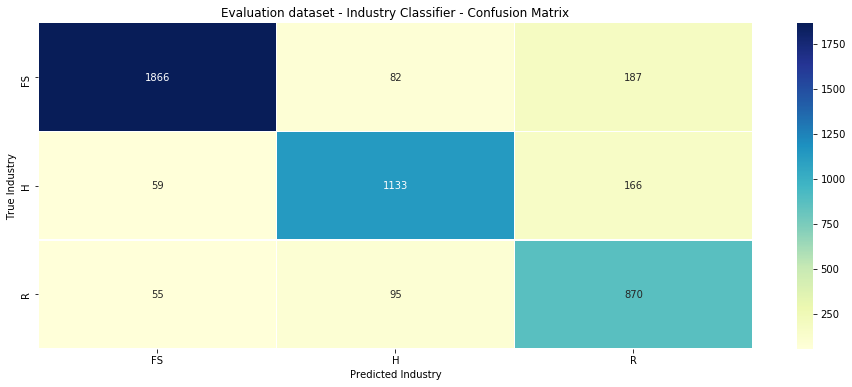

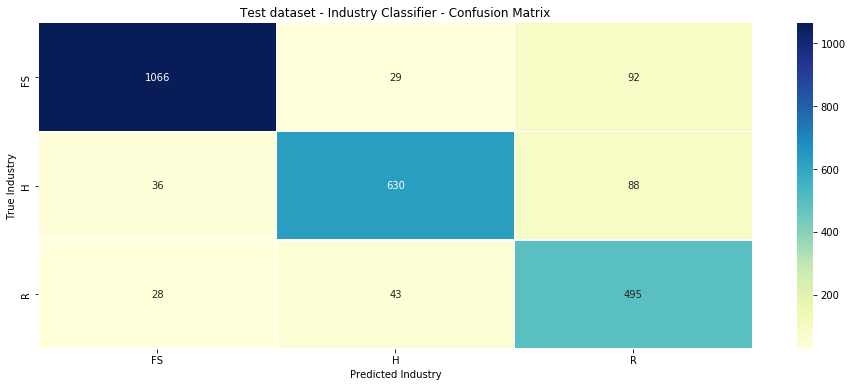

In [ ]:
print_evaluation_metrics(xgb_model, evaluation_type='All')

### **Feature Importance**

#### **Feature Importance df generation**

In [ ]:
feature_importance_df = pd.DataFrame(xgb_model.feature_importances_, index=X_train.columns).sort_values(by=0, ascending=True)

In [ ]:
feature_importance_df = feature_importance_df.reset_index().rename(columns={'index': 'Feature', 0: 'Importance'})

Feature  Importance
0               H_primary care    0.000000
1          FS_personal banking    0.000000
2        FS_commercial banking    0.000000
3            H_clinical trials    0.000000
4                     H_cancer    0.000000
..                         ...         ...
295                   R_retail    0.021620
296   description_tfidf_invest    0.024982
297             FS_investments    0.025332
298  description_tfidf_patient    0.027964
299                 H_medicine    0.035166

[300 rows x 2 columns]

#### **Top n important features**

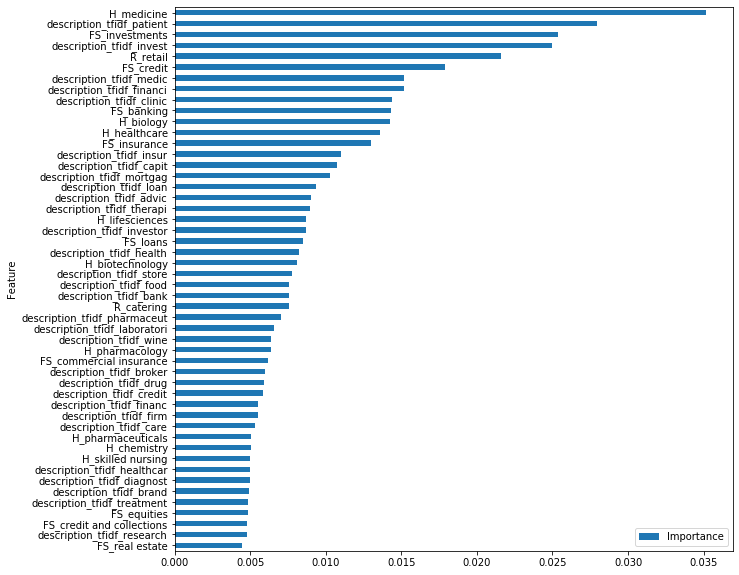

In [ ]:
n = 50
ax = feature_importance_df.tail(n).plot.barh(x='Feature', y='Importance', figsize=(10,10))

#### **Bottom n important features**

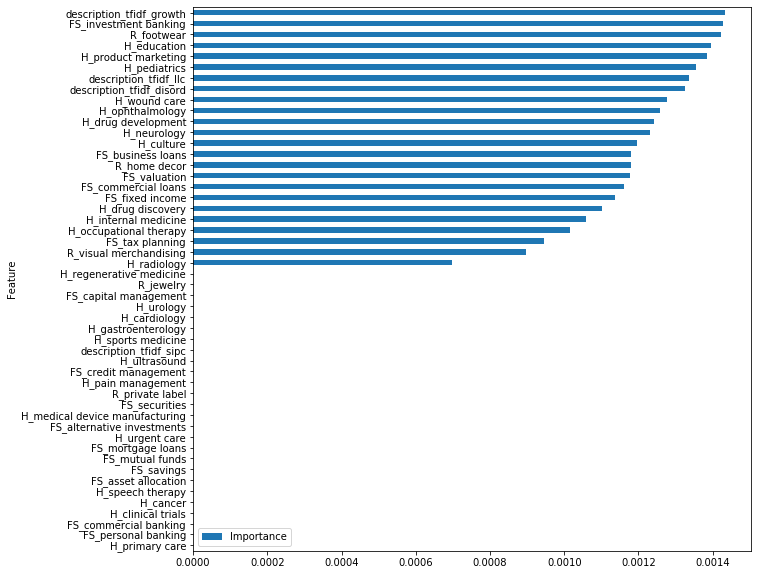

In [ ]:
n = 50
ax = feature_importance_df.head(n).plot.barh(x='Feature', y='Importance', figsize=(10,10))

#### **Select best features**

In [ ]:
#feature_importance_df[feature_importance_df['Feature']=='RAND_Feature']

In [ ]:
#best_features_list = feature_importance_df[2734:]['Feature'].to_list()

In [ ]:
#pickle.dump(best_features_list, open("best_features.pickle", "wb"))

## **Save Winning Model**

In [ ]:
pickle.dump(xgb_model, open("best_industry_classifier.pickle", "wb"))

# **Apply prediction - Production**

## **Define prediction logic**

In [ ]:
CLASS_PREDICTION_COLUMN = "Predicted Industry"
INCONCLUSIVE_STATUS = "Inconclusive"
PROBABILITY_THRESHOLD = 0.8

def apply_class_prediction(features_df, model):
    df_w_class = predict_class(features_df, model)
    df_w_proba, proba_columns = predict_probabilities(features_df, model)
    df_with_class_prediction = join_predictions([features_df, df_w_proba, df_w_class])
    df_with_class_prediction_columns = list(df_with_class_prediction.columns.values)
    predicted_prob_columns = [column for column in df_with_class_prediction_columns if "predcicted_prob" in column]
    df_with_class_prediction = apply_probability_threshold(df_with_class_prediction,
                                                           proba_columns=predicted_prob_columns)
    return df_with_class_prediction


def apply_probability_threshold(df, proba_columns):
    df['raw score'] = df.apply(lambda x: apply_threshold(x, predicted_prob_columns=proba_columns), axis=1)
    inconclusive_condition = (df['raw score'] < PROBABILITY_THRESHOLD)
    df.loc[inconclusive_condition, CLASS_PREDICTION_COLUMN] = INCONCLUSIVE_STATUS
    df.drop('raw score', axis=1, inplace=True)
    return df


def apply_threshold(row, predicted_prob_columns):
    probabilities_sorted_list = sorted(row[predicted_prob_columns], reverse=True)
    p0 = probabilities_sorted_list[0]
    p_ = 0
    for prob_index, probability in enumerate(probabilities_sorted_list[1:]):
        prob_index += 1
        p_ = p_ + (p0 - probability) * (1 / prob_index)
    raw_score = p0 + p_
    return raw_score


def join_predictions(df_list):
    df_with_class_prediction = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True),
                                      df_list)
    return df_with_class_prediction


def predict_probabilities(features_df, model):
    classes_ordered_list = model.classes_
    preds_proba = model.predict_proba(features_df)
    proba_columns = [f"predcicted_prob - {predeicted_class}" for predeicted_class in classes_ordered_list]
    df_w_proba = pd.DataFrame(preds_proba, columns=proba_columns, index=features_df.index)
    return df_w_proba, proba_columns


def predict_class(features_df, model):
    preds_class = model.predict(features_df)
    df_w_class = pd.DataFrame(preds_class, columns=[CLASS_PREDICTION_COLUMN], index=features_df.index)
    df_w_class.loc[:, CLASS_PREDICTION_COLUMN] = df_w_class[CLASS_PREDICTION_COLUMN].str.replace(";", "", regex=True)
    return df_w_class

## **Define Performance matrics function**

In [ ]:
def visualize_performance_exc_inconclusive(dataset, df_w_prediction, y_true, model):    
    df_w_prediction_no_inconclusive = df_w_prediction.loc[df_w_prediction[CLASS_PREDICTION_COLUMN]!=INCONCLUSIVE_STATUS,:]
    y_conclusive = y_true[df_w_prediction_no_inconclusive.index.values]
    y_pred_conclusive = df_w_prediction_no_inconclusive[CLASS_PREDICTION_COLUMN]
    class_labels = model.classes_

    number_of_conclusive = len(y_pred_conclusive)
    total_number_of_records = len(df_w_prediction)
    predicted_records_percentage = round((number_of_conclusive / total_number_of_records) * 100,2)
    number_of_inconclusive_records = (total_number_of_records - number_of_conclusive)

    print(f"{dataset} dataset Metrics:")
    print(f'\n% of predicted Records: {predicted_records_percentage}%\n# of inconclusive records: {number_of_inconclusive_records}\n\n')
    cm = pd.DataFrame(confusion_matrix(y_conclusive, y_pred_conclusive), index=class_labels, columns=class_labels)
    plot_confusion_matrix(cm, class_labels=class_labels, class_name='Industry', dataset_type=dataset)
    print(classification_report(y_conclusive, y_pred_conclusive))

## **Apply Industry Prediction & Performance analysis - with threshold**

In [ ]:
dataset_dict = {'evaluation': (X_evaluation, y_evaluation), 'test': (X_test, y_test)} #'train':(X_train, y_train), 

evaluation dataset Metrics:

% of predicted Records: 96.21%
# of inconclusive records: 171


              precision    recall  f1-score   support

          FS       0.95      0.89      0.92      2069
           H       0.88      0.85      0.87      1309
           R       0.73      0.87      0.79       964

    accuracy                           0.87      4342
   macro avg       0.85      0.87      0.86      4342
weighted avg       0.88      0.87      0.87      4342

test dataset Metrics:

% of predicted Records: 96.73%
# of inconclusive records: 82


              precision    recall  f1-score   support

          FS       0.95      0.91      0.93      1158
           H       0.91      0.86      0.88       725
           R       0.75      0.89      0.82       542

    accuracy                           0.89      2425
   macro avg       0.87      0.88      0.88      2425
weighted avg       0.90      0.89      0.89      2425



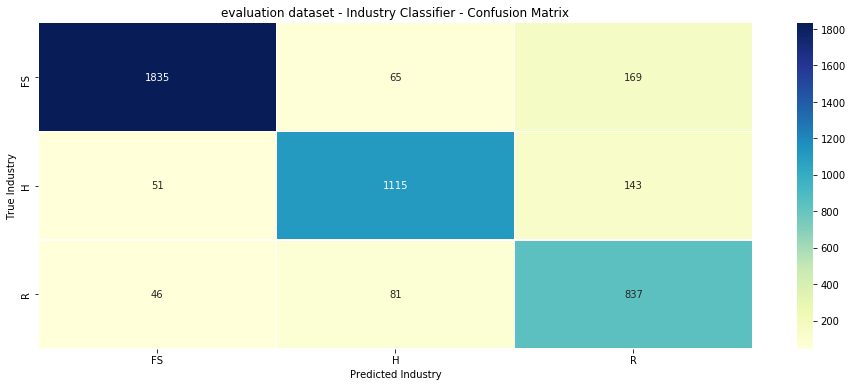

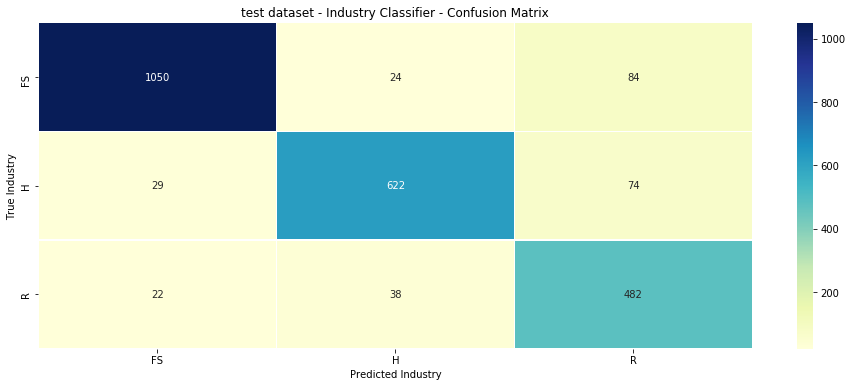

In [ ]:
results_dfs_dict = {}
for dataset, (X, y) in dataset_dict.items():
    df_w_prediction = apply_class_prediction(features_df=X, model=xgb_model)
    results_dfs_dict[dataset] = df_w_prediction
    visualize_performance_exc_inconclusive(dataset=dataset, df_w_prediction=df_w_prediction, y_true=y, model=xgb_model)

### **Test set - Inconclusive Analysis**

In [ ]:
results_dfs_dict['test'].loc[results_dfs_dict['test'][CLASS_PREDICTION_COLUMN]==INCONCLUSIVE_STATUS,:].head()

FS_investment management  ...  Predicted Industry
Record_Id                            ...                    
12397                           0.0  ...        Inconclusive
26624                           0.0  ...        Inconclusive
31893                           0.0  ...        Inconclusive
2025                            0.0  ...        Inconclusive
30696                           0.0  ...        Inconclusive

[5 rows x 304 columns]

In [ ]:
results_dfs_dict['test'][CLASS_PREDICTION_COLUMN].value_counts()

FS              1101
H                684
R                640
Inconclusive      82
Name: Predicted Industry, dtype: int64

## **Apply Industry Prediction on a new external file**

In [ ]:
test_file_path = r'industry_classifier_data.csv'
row_id = 'Record_Id'

def apply_prediction():
    df_test = pd.read_csv(test_file_path, encoding="UTF-8", index_col=row_id)
    df_test_transformed = industry_pipeline.transform(df_test)
    model = pickle.load(open("best_industry_classifier.pickle", "rb"))
    df_test_transformed_scored = apply_class_prediction(features_df=df_test_transformed, model=model)
    df_test_final_scored = pd.merge(df_test, df_test_transformed_scored[CLASS_PREDICTION_COLUMN], how='left', left_index=True, right_index=True)
    output_path = test_file_path.replace('.csv', '_w_industry_prediction.csv')
    df_test_final_scored.to_csv(output_path, encoding="UTF-8")

if __name__ == "__main__":
    apply_prediction()
